In [1]:
%load_ext autoreload
%autoreload 2
import os
import pathlib

os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
os.environ["BART_TOOLBOX_PATH"] = "/Users/chunxuguo/bart"

import torch
import torchopt
from einops import rearrange, reduce
from fastmri import complex_abs
from fastmri.data import mri_data, subsample, transforms

from ese5934_project.datasets.csm_estimation import espirit_csm_estimation
from ese5934_project.models.operators import ForwardModel, MaskedForwardModel
from ese5934_project.tasks.mri_reconstruction_2d import reconstruct

# Create a mask function
mask_func = subsample.RandomMaskFunc(center_fractions=[0.08], accelerations=[1])


def data_transform(kspace, mask, target, data_attributes, filename, slice_num):
    # Transform the data into appropriate format
    # Here we simply mask the k-space and return the result
    kspace = transforms.to_tensor(kspace * 1e5)
    mean = reduce(kspace, "ch h w complex-> () () complex", "mean")
    std = reduce(kspace, "ch h w complex-> () () complex", torch.std)
    print(mean, std)
    print(mean.shape, std.shape)
    masked_kspace, mask, num_low_frequencies = transforms.apply_mask(kspace, mask_func)
    csm = transforms.to_tensor(espirit_csm_estimation(kspace, num_low_frequencies))
    # kspace = kspace
    # masked_kspace = masked_kspace
    # csm = csm
    # mask = rearrange(mask, "() () w ()-> () () w")
    csm = rearrange(csm, "() h w ch complex-> ch h w complex")
    return kspace, (mean, std), masked_kspace, mask, csm


dataset = mri_data.SliceDataset(
    root=pathlib.Path("/Users/chunxuguo/ese5934_project/data"),
    transform=data_transform,
    challenge="multicoil",
)

[2024-02-15 15:18:00,628] torch.distributed.elastic.multiprocessing.redirects: [WARNING] NOTE: Redirects are currently not supported in Windows or MacOs.


# Grid Field (Voxel Representation)

In [22]:
from ese5934_project.models.GridField import Grid

optimizer = torchopt.adam(lr=0.001)
kspace, (mean, std), masked_kspace, mask, csm = dataset[15]
field = Grid((640, 368), mean, std)

python(48298) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Done.


In [ ]:
print(masked_kspace.shape, mask.shape, csm.shape)

In [6]:
params, image_list = reconstruct(
    field,
    torch.rand(1, 2),
    masked_kspace,
    csm,
    mask,
    optimizer=optimizer,
    iterations=200,
    device=torch.device("mps"),
)

iteration 1, loss: 0.0011084506986662745
iteration 2, loss: 0.20276296138763428
iteration 3, loss: 0.013381535187363625
iteration 4, loss: 0.044270891696214676
iteration 5, loss: 0.11586011946201324
iteration 6, loss: 0.08364998549222946
iteration 7, loss: 0.021141286939382553
iteration 8, loss: 0.0014303281204774976
iteration 9, loss: 0.029668185859918594
iteration 10, loss: 0.05672051012516022
iteration 11, loss: 0.049642279744148254
iteration 12, loss: 0.021677490323781967
iteration 13, loss: 0.0024766603019088507
iteration 14, loss: 0.006339809857308865
iteration 15, loss: 0.022433355450630188
iteration 16, loss: 0.030351584777235985
iteration 17, loss: 0.022597357630729675
iteration 18, loss: 0.008582262322306633
iteration 19, loss: 0.0015756580978631973
iteration 20, loss: 0.005609204061329365
iteration 21, loss: 0.013487718068063259
iteration 22, loss: 0.015842515975236893
iteration 23, loss: 0.010701170191168785
iteration 24, loss: 0.0038123968988656998
iteration 25, loss: 0.00

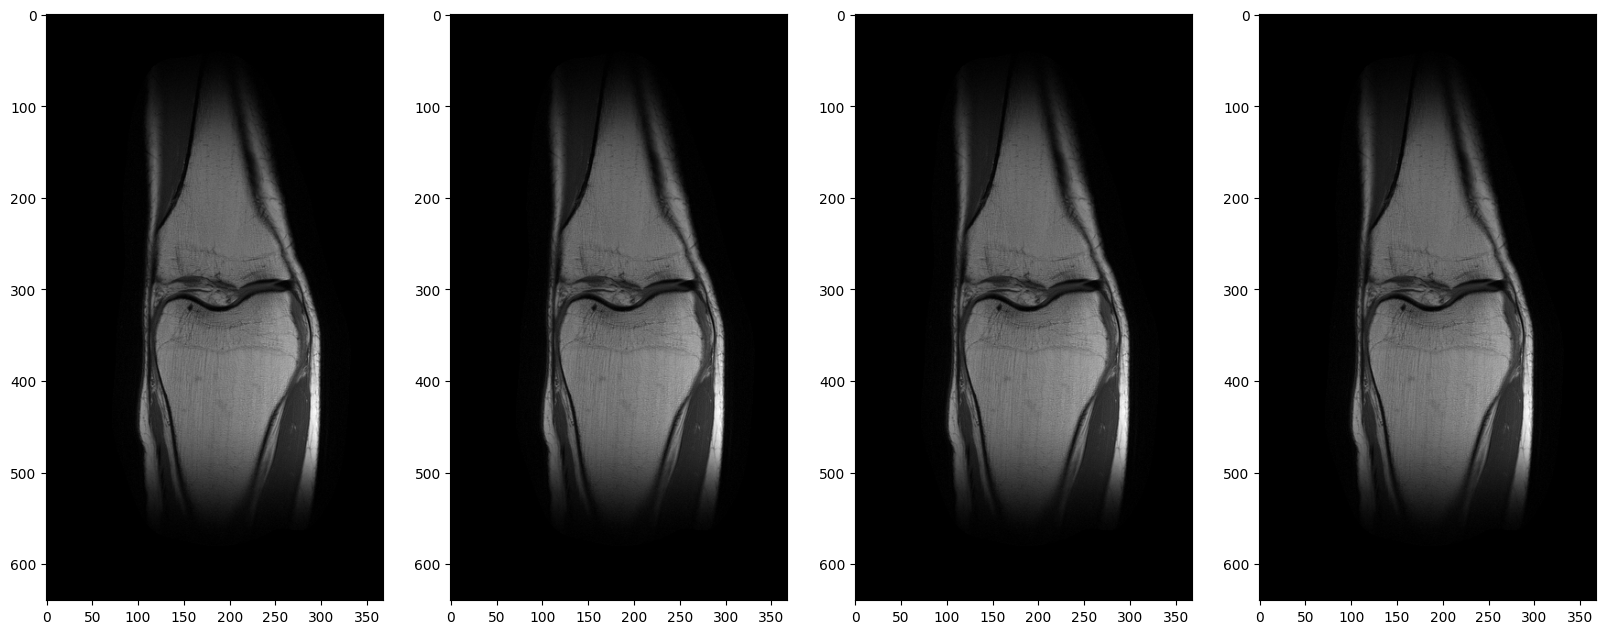

In [7]:
import matplotlib.pyplot as plt

# there are 20 images in the list,
# we want to plot them in a grid of 4x5
fig, axs = plt.subplots(1, 4, figsize=(20, 10))
for i, image in enumerate(image_list):
    axs[i % 5].imshow(complex_abs(image), cmap="gray")

# SIREN

In [12]:
from ese5934_project.models.SIREN import Siren, get_coordinates

device = torch.device("mps")
size = (640, 368)
coords = get_coordinates(size)
kspace, (mean, std), masked_kspace, mask, csm = dataset[15]
field = Siren(
    size,
    mean.to(device),
    std.to(device),
    in_features=2,
    out_features=2,
    hidden_features=128,
    hidden_layers=3,
    outermost_linear=True,
)
optimizer = torchopt.adamw(lr=1e-3)
# 1e-4 1.092077389
# 1e-3 0.09540542
# 1e-2

tensor([[[6.0409e-04, 7.4484e-05]]]) tensor([[[1.2870, 1.2171]]])
torch.Size([1, 1, 2]) torch.Size([1, 1, 2])
Done.


In [14]:
params, image_list = reconstruct(
    field,
    coords,
    masked_kspace,
    csm,
    mask,
    optimizer=optimizer,
    iterations=1000,
    device=device,
)

iteration 1, loss: 3.1384434700012207
iteration 2, loss: 3.086134433746338
iteration 3, loss: 3.0302047729492188
iteration 4, loss: 3.0349299907684326
iteration 5, loss: 2.975076675415039
iteration 6, loss: 2.9119138717651367
iteration 7, loss: 2.8785243034362793
iteration 8, loss: 2.8207733631134033
iteration 9, loss: 2.7792627811431885
iteration 10, loss: 2.7183377742767334
iteration 11, loss: 2.668926477432251
iteration 12, loss: 2.6159329414367676
iteration 13, loss: 2.561182975769043
iteration 14, loss: 2.5051016807556152
iteration 15, loss: 2.450885772705078
iteration 16, loss: 2.3958685398101807
iteration 17, loss: 2.342804193496704
iteration 18, loss: 2.2900750637054443
iteration 19, loss: 2.2375874519348145
iteration 20, loss: 2.1876962184906006
iteration 21, loss: 2.1375045776367188
iteration 22, loss: 2.092164993286133
iteration 23, loss: 2.0483217239379883
iteration 24, loss: 2.016599655151367
iteration 25, loss: 1.994504690170288
iteration 26, loss: 1.9379788637161255
iter

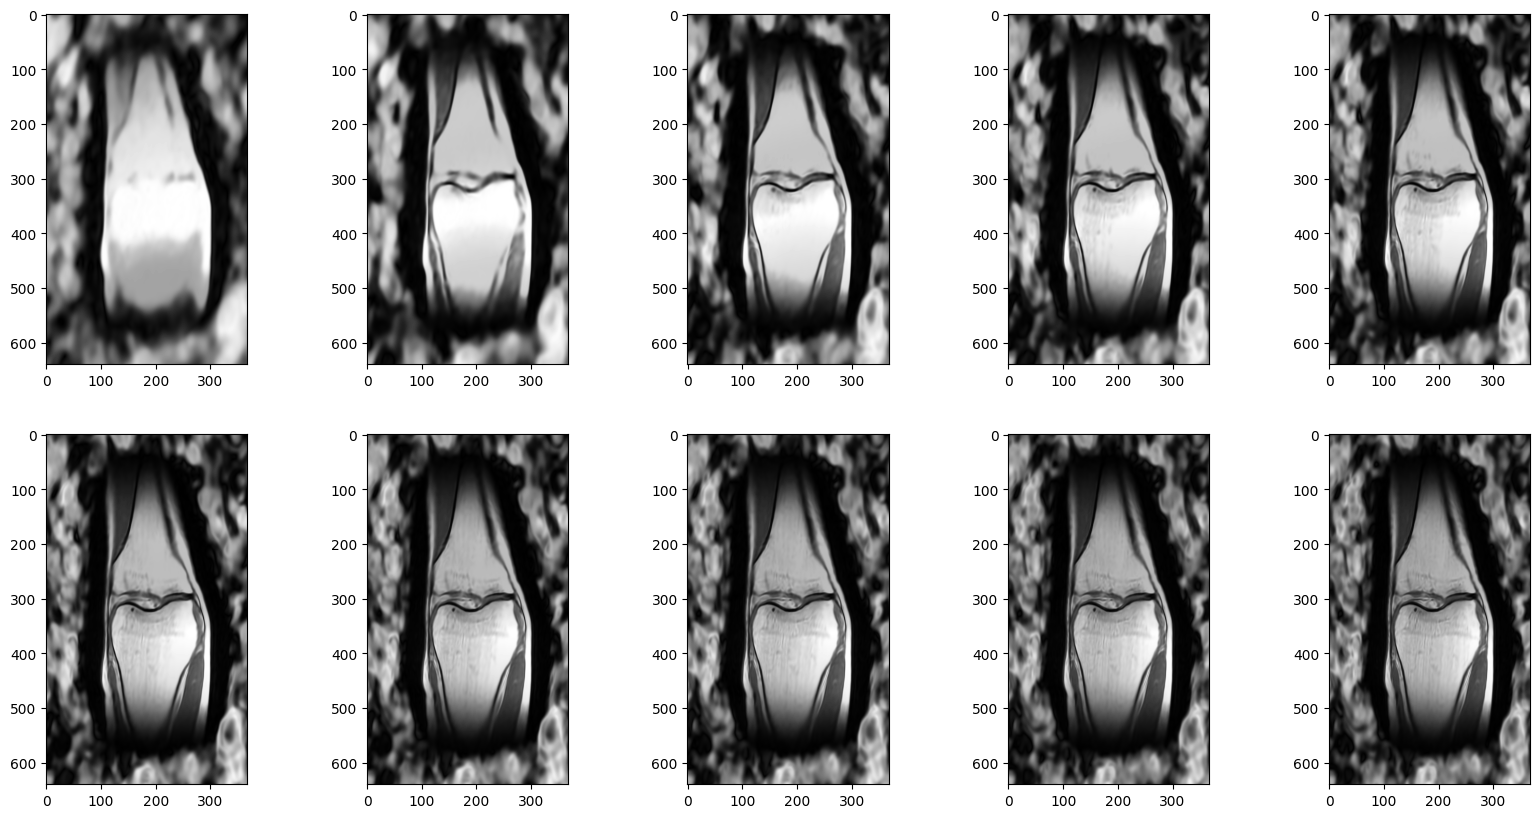

In [ ]:
import matplotlib.pyplot as plt

# there are 20 images in the list,
# we want to plot them in a grid of 4x5
fig, axs = plt.subplots(4, 5, figsize=(20, 10))
for i, image in enumerate(image_list):
    axs[i // 5, i % 5].imshow(complex_abs(image), cmap="gray")